In [31]:
import sys, time, re
import os
import pandas as pd
import pylab as plt
from importlib import reload
%matplotlib inline
import itertools as it
import numpy as np
from multiprocessing import Pool as ThreadPool
import  Levenshtein
from tqdm import tqdm_notebook as tqdm
import pickle
import gc
import sys
sys.path.append('../scripts')

import ml_utils as utils
reload(utils)

<module 'ml_utils' from '../scripts/ml_utils.py'>

### Generate true mapping

In [ ]:
utils.generate_true_mapping(from_raw=False)

In [4]:
df = utils.read_combine_df(from_raw=False, merge_how='outer')

       uid_inst           uname          name_inst    uid_vk          name_vk
0  7.510266e+08       mrzelkin1     aleksej zelkin    5394.0    alexey zelkin
1  2.744159e+06         undruha  andrey gnelitskiy   22884.0  andre undrukhov
2  4.157858e+09       vadimbhai     abhairov vadim   23754.0    vadim reutsky
3  3.893359e+08  superov_sergey     sergey superov   89831.0   sergey superov
4  1.992385e+08       smilychka       nastja gogol  103177.0     nastya gogol


### Read graphs

In [12]:
%%time
reload(utils)
g1_fname = 'vk_lid_rid.csv'
g2_fname = 'inst_lid_rid.csv'
G1, G2 = utils.read_gs(g1_fname, g2_fname, from_raw = False)

G1 has all fname True
G2 has all fname False
CPU times: user 512 ms, sys: 44 ms, total: 556 ms
Wall time: 597 ms


### Read matches and start ML step

In [13]:
threshold=91
is_repeat = True
matches_file_name = 'matches_s_01_th_091_t_10-12_13:19.pickle'

matches = utils.read_matches(matches_file_name, threshold, is_repeat)
utils.precision_recall(matches)

me/ildar/projects/pycharm/social_network_revealing/graphmatching/matches/repeat/091/matches_s_01_th_091_t_10-12_13:19.pickle
matches len 4765
(78897392, 608311198)
(20158885, 482179932)
(12852529, 294223340)
(239645190, 53256746)
(134652490, 4145166609)


(0.9565582371458552, 0.18484123443773065)

### 1 step

In [32]:
reload(utils)
utils.gen_train_data(matches, G1, G2, save_to = 'train_data_matches', threads = 1)

Cache loaded 24800 20794
Start thread 0


HBox(children=(IntProgress(value=0, max=4765), HTML(value='')))


Clear cache 0 0


In [34]:
features, labels = utils.load_train_data('train_data_matches')
print(len(features[0]))
len(features), len(labels)

86


(11384, 11384)

### Generate 2 step test data (data/generate/test2_predicted.pickle)

In [ ]:
df_l_others = utils.read_clean_csv(fname='vk_personal2.csv', from_raw = False)
df_l_others.rename(columns={'uid_vk': 'uid'}, inplace=True)
df_r_others = utils.read_clean_csv(fname='inst_personal.csv', from_raw = False)
df_r_others.rename(columns={'uid_inst': 'uid'}, inplace=True)

In [ ]:
df_l_others_90, df_r_others_90 = utils.filter_others_from_predicted(df_l_others, df_r_others, matches)

In [ ]:
reload(utils)
name_sim_threshold = 90
results_90, lid_rid_90 = utils.ml_iteration(df_l_others_90, df_r_others_90, forest, G1, G2, 
                    name_sim_threshold, threads = 6, save_to='lid_rid_90')

In [ ]:
utils.precision_recall(lid_rid_90)

### Generate 3 step test data (data/generate/test3_data.pickle)

In [ ]:
def prepare_data_for_threads(df_l, df_r, model, G1, G2, threads, name_sim_threshold = None):
    data = []

    thr_size = len(df_l) // threads
    for i in range(threads):
        s = i * thr_size
        e = i * thr_size + thr_size
        d = {
            'thread_num': i,
            'vals_l': df_l[s:e] if i + 1 < threads else df_l[s:],
            'vals_r': df_r,
            'model': model,
            'G1': G1,
            'G2': G2,
        }
        if name_sim_threshold:
            d['name_sim_threshold'] =  name_sim_threshold
        data.append(d)
    return datareshape((1, -1)

In [ ]:
reload(utils)

def collect_true(data):
    df_vals_l = data['vals_l']
    df_vals_r = data['vals_r']
    model = data['model']
    G1 = data['G1']
    G2 = data['G2']
    thread_num = data['thread_num']

    res_list = []
    lev = Levenshtein
    print('Start', thread_num)
    true_count = 0
    for row_l in tqdm(df_vals_l):
        for row_r in tqdm(df_vals_r):
#             ratio = lev.ratio(row_l[1], row_r[1])
            x = np.array(utils.feature(G1, row_l, G2, row_r)).reshape((1, -1))
            if model.predict(x) == 1:
                true_count += 1
                res_list.append((row_l, row_r)) # ratio
    total_count = len(df_vals_l) * len(df_vals_r)
    print('Thread', thread_num, 'True =', true_count, 'False =', total_count - true_count,
          'Total =', total_count, 'True/Total =', true_count / total_count)
    return res_list

def get_test_3_step_palalel(true_1step, true_2step, model, G1, G2, threads=4):
    
    
    filter_g = lambda G, col_num: list(set(G.nodes()) - (set((x[col_num] for x in true_1step)) | 
                                                      set((x[col_num] for x in true_2step))))
    df_l = filter_g(G1, 0)
    df_r = filter_g(G2, 1)
    data = utils.prepare_data_for_threads(df_l, df_r, forest, G1, G2, threads=threads)
    with ThreadPool(threads) as pool:
        results = pool.map(collect_true, data)
    439850
    for i, res in enumerate(results):
        print(i, 'true count', len(res))
    pickle.dump(results, open(os.path.join(utils.folder_gen, 'test3_predicted.pickle'), "wb"))
    utils.f_set1s = dict()
    utils.f_set2s = dict()
    return results

get_test_3_step_palalel(matched_1step, results2, forest, G1, G2, threads=5)
gc.collect()

### Name threshold 82

In [ ]:
lid_rid_90 = pickle.load(open(os.path.join(utils.folder_gen, 'lid_rid_90.pickle'), "rb"))
# ToDo retrain model there
df_l_others_80, df_r_others_80 = filter_others_from_predicted(vk_others, inst_others, lid_rid_90)

lid_rid_80 = ml_iteration(df_l_others, df_r_others, forest, G1, G2, 
                    name_sim_threshold = 0.8, threads = 6, save_to = 'lid_rid_80')

gc.collect()

In [ ]:
utils.gen_train_data(lid_rid_80, G1, G2, save_to = 'train_data_80')

In [ ]:
utils.precision(lid_rid_80)

In [ ]:
from scipy.stats import ks_2samp

def dist_sim(G1, n, G2, m):
    sl = [v.degree() for v in vl.neighbors()]
    sr = [v.degree() for v in vr.neighbors()]
    return ks_2samp(sl, sr)

### Name threashold 70

In [ ]:
lid_rid_80 = pickle.load(open(os.path.join(utils.folder_gen, 'lid_rid_80.pickle'), "rb"))

model_70 = utils.retrain_model(model_80, ['train_data_matched', 'train_data_90', 'train_data_80', ])

df_l_others_70, df_r_others_70 = utils.filter_others_from_predicted(df_l_others_80, df_r_others_80, lid_rid_80)

lid_rid_70 = utils.ml_iteration(df_l_others_70, df_r_others_70, model_70, G1, G2, 
                    name_sim_threshold = 0.7, threads = 6, save_to = 'lid_rid_70')

gc.collect()

In [ ]:
utils.gen_train_data(lid_rid_70, G1, G2, save_to = 'train_data_70')

In [ ]:
utils.precision(lid_rid_70)

In [ ]:
def overall_precision():
    ls = []
    for t in (6,7,8,9):
        lid_rid = pickle.load(open(os.path.join(utils.folder_gen, 'lid_rid_%d0.pickle' % t), "rb"))
        ls += lid_rid
        
    ls += [(x[0], x[1]) for x in pd.read_csv(os.path.join(utils.folder_gen, 'true_mapping.csv'))[:2500].values.tolist()]
    utils.precision(ls)
    
overall_precision()

#### Features cache

In [ ]:
utils.f_set1s = dict(pickle.load(open(os.path.join(utils.folder_gen, 'features_G1.pickle'), "rb")))
utils.f_set2s = dict(pickle.load(open(os.path.join(utils.folder_gen, 'features_G2.pickle'), "rb")))

### Name threashold 60

In [ ]:
lid_rid_70 = pickle.load(open(os.path.join(utils.folder_gen, 'lid_rid_70.pickle'), "rb"))

model_60 = utils.retrain_model(model_70, ['train_data_matched', 'train_data_90', 'train_data_80', 'train_data_70'])

df_l_others_60, df_r_others_60 = utils.filter_others_from_predicted(df_l_others_70, df_r_others_70, lid_rid_70)

lid_rid_60 = utils.ml_iteration(df_l_others_60, df_r_others_60, model_60, G1, G2, 
                    name_sim_threshold = 0.6, threads = 6, save_to = 'lid_rid_60')

gc.collect()

In [ ]:
utils.precision(lid_rid_60)

### Feature generation for ML on 1 step

In [ ]:
%%time

features, labels = utils.gen_train_data_1step('step1_data.pickle', from_raw=False)

In [ ]:
for a,b in it.islice(zip(features, labels), 2):
    print(a, b)

### ML models

In [19]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [39]:
# x_train, x_test, y_train, y_test = train_test_split(
#      features, labels, test_size=0.3, random_state=42)
x_train, y_train = features, labels

In [37]:
len(x_train[0]), len(features[0])

(86, 86)

In [42]:
forest = RandomForestClassifier(n_estimators = 400, criterion ='gini',
                        bootstrap = True, max_features = 'auto' ,n_jobs=4)
forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [41]:
forest.score(x_test, y_test)

1.0

In [23]:
gbc = GradientBoostingClassifier(n_estimators=100)
gbc.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [24]:
gbc.score(x_test, y_test)

0.7258765575195596

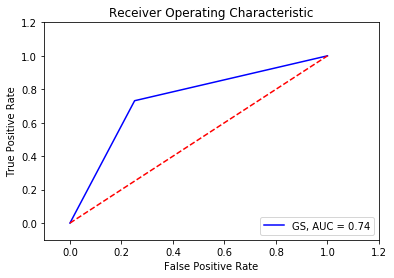

In [26]:
y_score = forest.predict(x_test)
y_true = y_test

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='GS, AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [43]:
pickle.dump(forest, open(os.path.join(utils.folder_gen, 'forest.pickle'), 'wb'))

In [ ]:
forest2 = pickle.load(open(os.path.join(utils.folder_gen, 'forest.pickle'), 'rb'))

In [30]:
len(features[0])

85

### Try keras ML

In [ ]:
from keras.losses import mean_squared_error
from keras.models import Sequential, Model
from keras.layers import LSTM,Activation,Dense, Lambda, Input, Concatenate, Add, Reshape, Dropout
from keras.optimizers import Adam
from keras.metrics import mean_squared_error
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.engine.topology import Layer
from keras.initializers import RandomNormal
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import multiply
from keras import backend as K
from keras.constraints import non_neg
import tensorflow as tf
import keras

In [ ]:
#Формирование модели
model_number = 0
best_weights_filepath = './best_weights.hdf5'
log_path = './logs_nn/'

In [ ]:
def get_model(x_train,
              y_train,
              model_number=0,
              best_weights_filepath=best_weights_filepath,
              log_path='./logs_nn/'):
    '''hyperparams'''
#     learning_rate = 1e-3
#     reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=0.0001)
#     optimiser = Adam(lr=learning_rate)
    dense_activation = 'relu'
    dense_1layer_nn_count_coef = 1
    dense_2layer_nn_count_coef = 0.5
    
    out_len = 1
    feature_amount = len(x_train[0])
    in_shape = (feature_amount, )
    
    ''' 1. Вход '''
    inputs = Input(shape=in_shape, name="in_data")

    inputs_transformed = BatchNormalization()(inputs)
    print('inputs_transformed', inputs_transformed.shape)
    ''' 6. Несколько полносвязных слоев '''
    dense_nn_count = int(dense_1layer_nn_count_coef * feature_amount)
    dense_model = Dense(units = dense_nn_count, activation = dense_activation)(inputs_transformed)
    print(dense_model.shape)
    dropout = Dropout(0.2)(dense_model)
    dense_nn_count = int(dense_2layer_nn_count_coef * feature_amount)
    dense_model = Dense(units = dense_nn_count, activation = dense_activation)(dense_model)
    print(dense_model.shape)
    output = Dense(units = out_len, activation = 'sigmoid', name='out_states')(dense_model)   
    print(dense_model.shape)
    
    model = Model(inputs, output)
    
    tb_callback = TensorBoard(log_dir=log_path + '/', histogram_freq=0, write_graph=True,
                              write_images=True)
    bm_callback = ModelCheckpoint(best_weights_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                                  mode='auto')
    
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy', 'binary_crossentropy'])
    return [model, [bm_callback, tb_callback]]

In [ ]:
!rm -rf ./logs_nn/

In [ ]:
[model, callbacks] = get_model(x_train, y_train, log_path = log_path+str(model_number))

In [ ]:
batch_size = 32
epochs = 1200

model.fit(x_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(x_test, y_test),
      initial_epoch = 0,
      callbacks = callbacks,
      verbose = 1
     )